In [ ]:
'''
COVERS
=========
REGRESSION
INTERPOLATION
OPTIMIZATION
CONSTRAINED OPTIMIZATION
INTEGRATION
'''

In [1]:
'''
Using a toy function that sort of represents the curving path of a financial instrument, let's apply
mathematical tools
'''

"\nUsing a toy function that sort of represents the curving path of a financial instrument, let's apply\nmathematical tools\n"

In [2]:
import numpy as np
from pylab import plt, mpl
plt.style.use('seaborn')
mpl.rcParams['font.family'] = 'serif'
%matplotlib inline

In [3]:
def f(x):
    return np.sin(x) + 0.5 * x

In [4]:
def create_plot(x, y, styles, labels, axlabels):
    plt.figure(figsize=(20,12))
    for i in range(len(x)):
        plt.plot(x[i], y[i], styles[i], label=labels[i]) # Nice general plotting function
        plt.xlabel(axlabels[0])
        plt.ylabel(axlabels[1])
    plt.legend(loc=0) # do your best mpl!

In [5]:
x = np.linspace(-2 * np.pi, 2 * np.pi, 50)

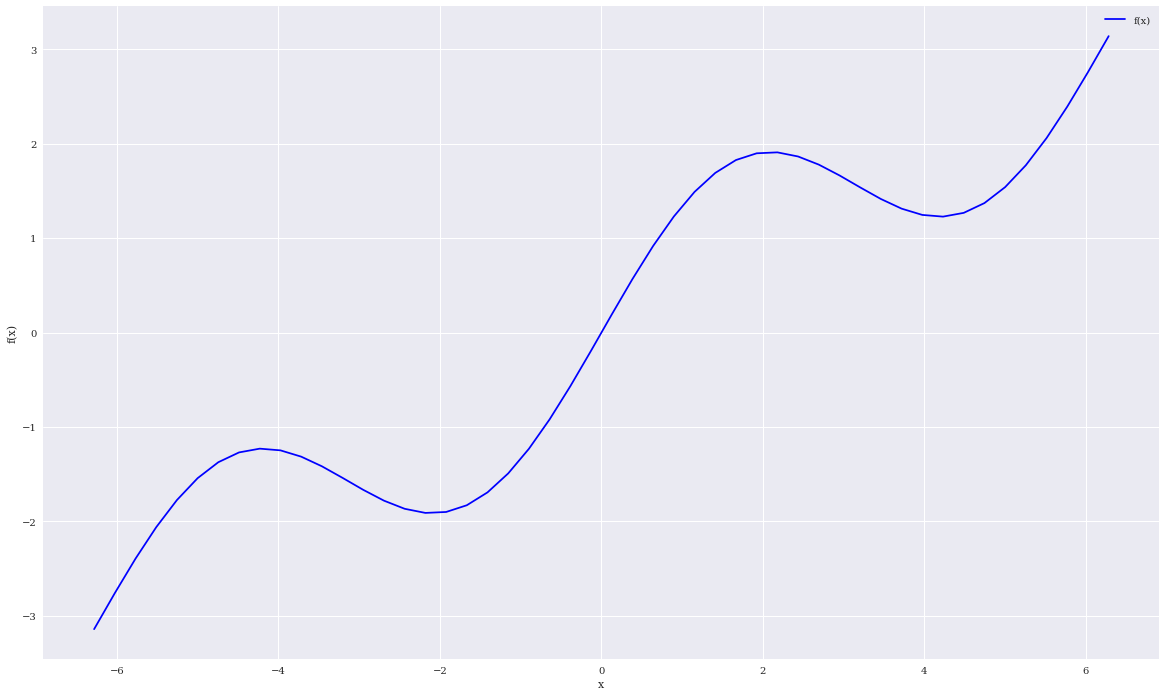

In [6]:
create_plot([x], [f(x)], ['b'], ['f(x)'], ['x', 'f(x)'])

In [7]:
'''
First up is regression
Linear regression finds the degree 1 polynomial (i.e. line) that minimize the squared errors
of the data points where x is the independent variable and y is the dependent variable

Output of Full is:
Regression parameters - highest degree first - in this case 1 (x), 0 (constant)
Residuals - squared sum of errors? check this!
Effective Rank
Singular Values - // TODO review SVD to give a good answer for this
Condition Number: The change in output y for a ∆x steptKPI
'''
res = np.polyfit(x, f(x), deg=1, full=True)
res # i.e. (4.288 * 10 ^ -1)x - (a very very very small number)

(array([ 4.28841952e-01, -1.31499950e-16]),
 array([21.03238686]),
 2,
 array([1., 1.]),
 1.1102230246251565e-14)

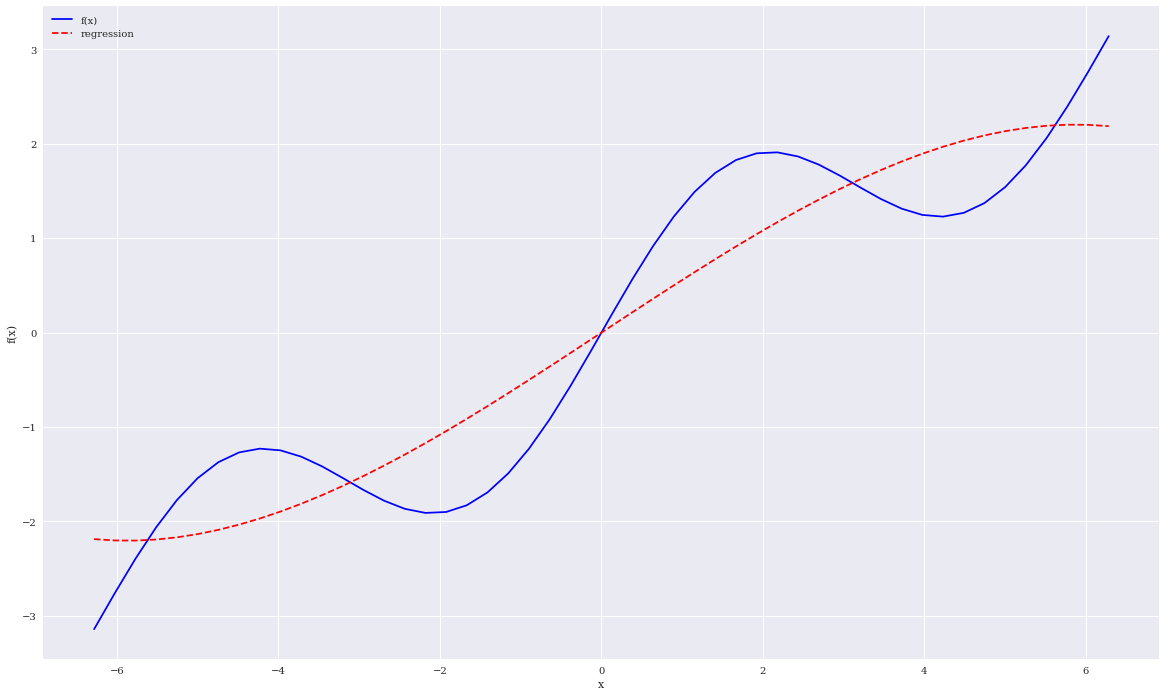

In [8]:
'''
That error number is very high - a higher degree polynomial can help us out
'''
reg = np.polyfit(x, f(x), deg=3)
ry = np.polyval(reg, x)
create_plot([x, x], [f(x), ry], ['b', 'r--'], ['f(x)', 'regression'], ['x', 'f(x)'])

In [9]:
'''
What if we went really wild and did a 9th degree polynomial?
'''
reg = np.polyfit(x, f(x), deg=9)
ry = np.polyval(reg, x)
np.allclose(f(x), ry) # are all of the values of these arrays very close?

False

In [10]:
np.mean((f(x) - ry) ** 2) # very very small mean squared error, good!

2.0214795375384566e-05

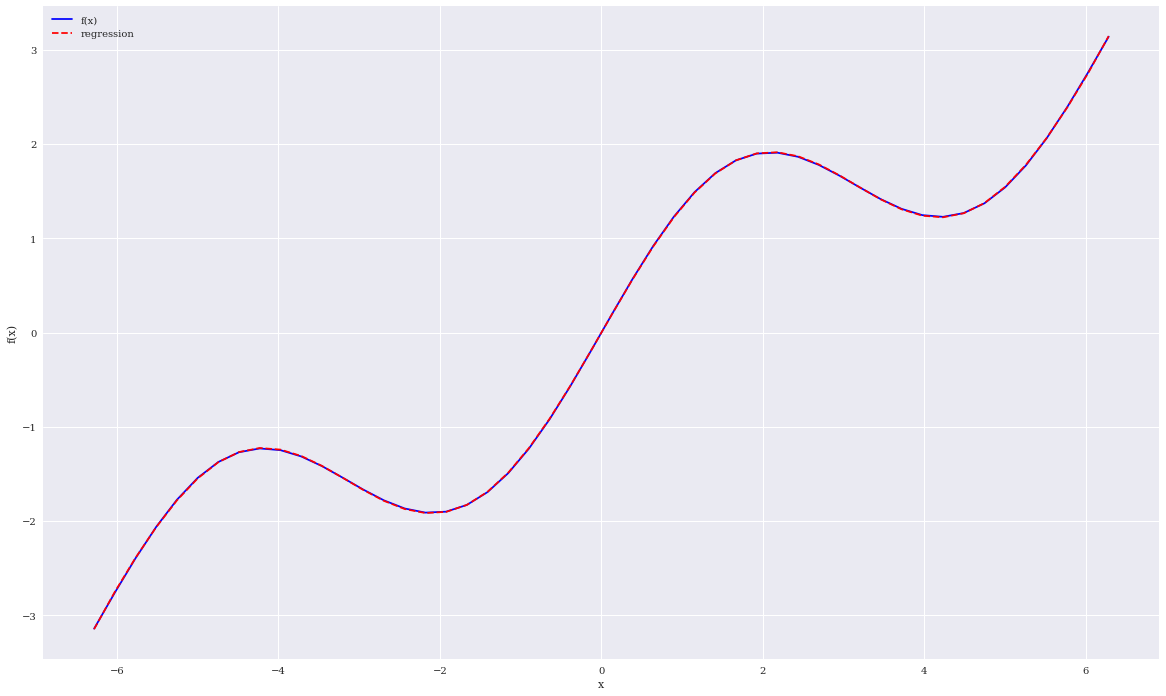

In [11]:
create_plot([x, x], [f(x), ry], ['b', 'r--'], ['f(x)', 'regression'], ['x', 'f(x)']) # Indistinguishable!

In [12]:
'''
For more control, you can also set the array of basis functions yourself - numpy.polyfit is actually calling
this method in the source code
'''
matrix = np.zeros((3 + 1, len(x))) # 3rd degree polynomial + a constant over length of x
matrix[3, :] = x ** 3
matrix[2, :] = x ** 2
matrix[1, :] = x
matrix[0, :] = 1

In [13]:
reg = np.linalg.lstsq(matrix.T, f(x), rcond=None)[0]

In [14]:
'''
# Note that a regression is just the dot product of a matrix of power coefficients and the regressor coefficients
'''
ry = np.dot(reg, matrix)

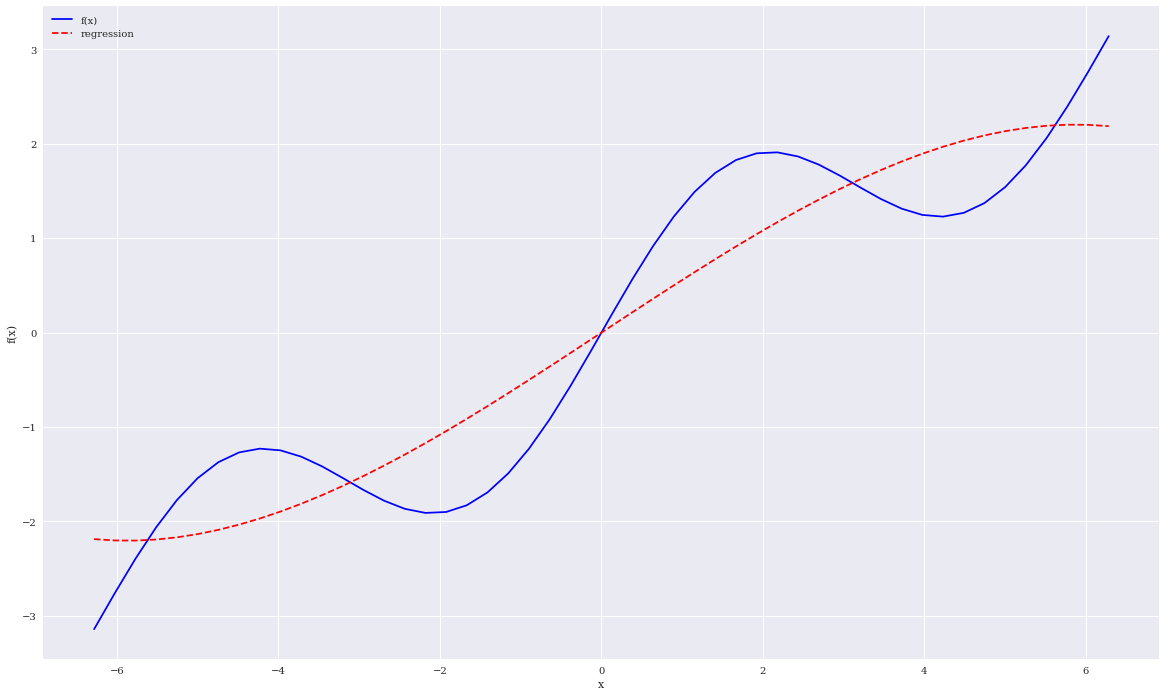

In [15]:
create_plot([x,x], [f(x), ry], ['b', 'r--'], ['f(x)', 'regression'], ['x', 'f(x)'])

In [16]:
matrix[3, :] = np.sin(x) # Replace cubic basis function with sin

In [17]:
reg = np.linalg.lstsq(matrix.T, f(x), rcond=None)[0]

In [18]:
ry = np.dot(reg, matrix)

In [19]:
np.allclose(f(x), ry) # Fit is perfect since we've added the characteristic function as a basis

True

In [20]:
np.mean((f(x) - ry) ** 2) # Vectorized mean squared error

3.404735992885531e-31

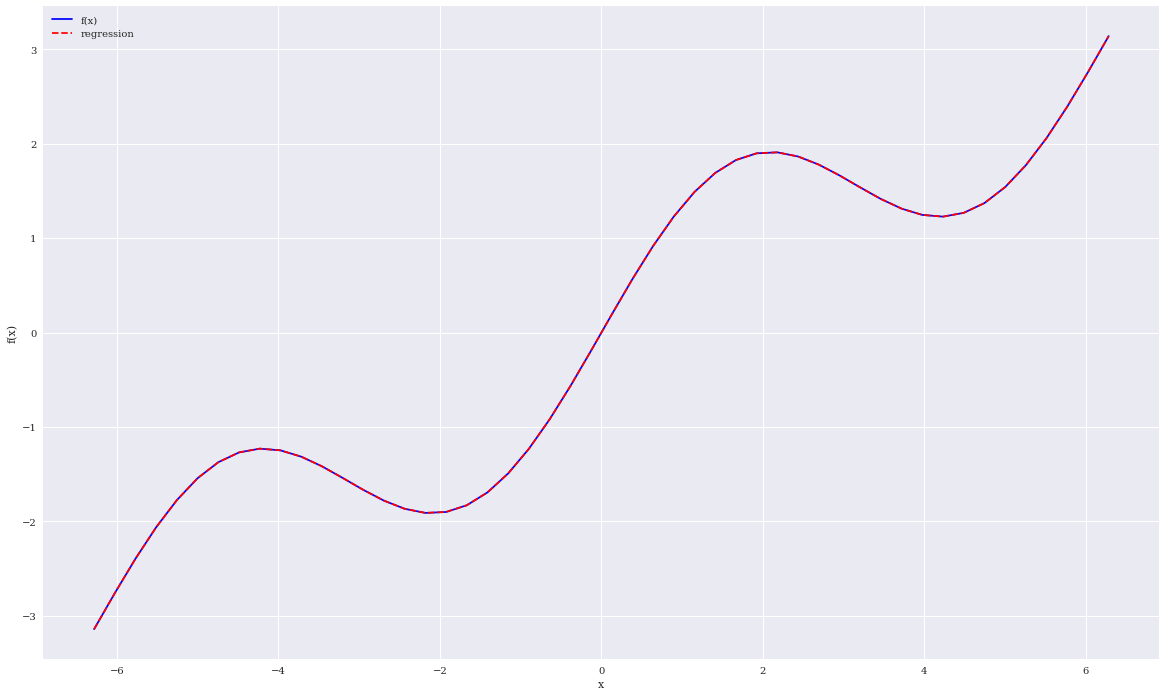

In [21]:
create_plot([x,x], [f(x), ry], ['b', 'r--'], ['f(x)', 'regression'], ['x', 'f(x)'])

In [22]:
# Add noise to data - show regression can handle it
xn = np.linspace(-2 * np.pi, 2 * np.pi, 50)
# standard_normal returns a draw from std normal distribution, -1 < x < 1
xn = xn + 0.35 * np.random.standard_normal(len(xn)) 
yn = f(xn) + 0.25 * np.random.standard_normal(len(xn))

In [23]:
reg = np.polyfit(xn, yn, deg=7)
ry = np.polyval(reg, xn)

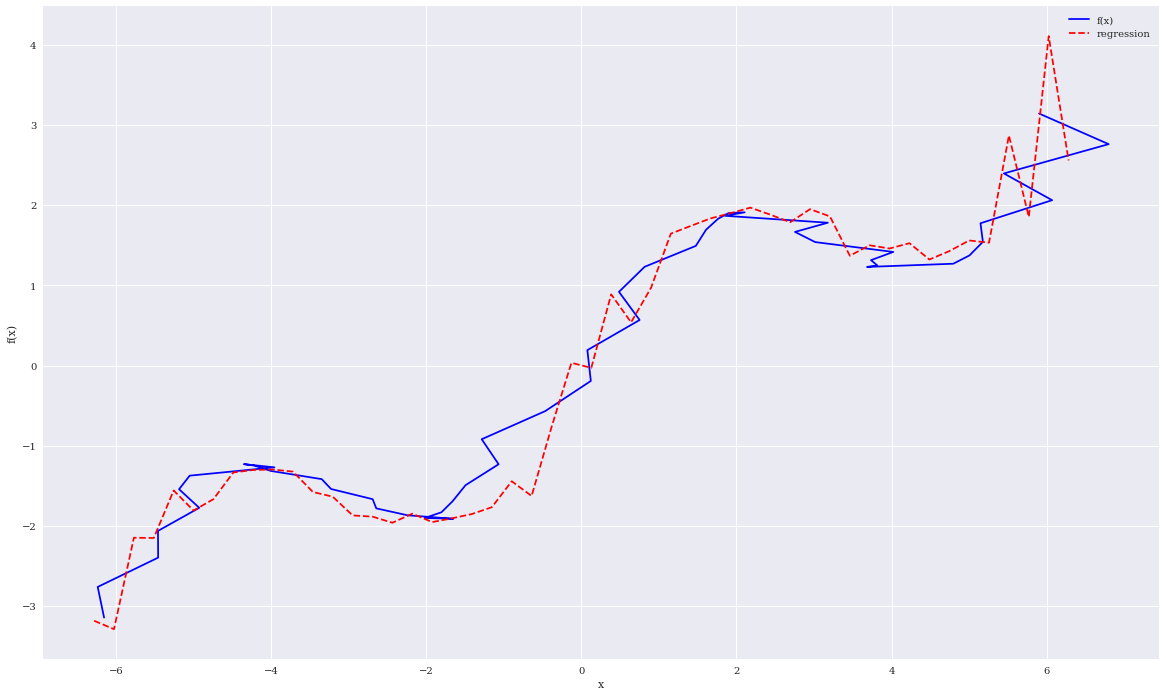

In [24]:
create_plot([xn, x], [f(x), ry], ['b', 'r--'], ['f(x)', 'regression'], ['x', 'f(x)'])

In [25]:
'''
Unsorted data can be regressed on as well - in this case that means sparse data that doesn't follow an
even interpolation/linear space

This means it is an effective tactic when dealing with values with uncertain timestamping:
    * Any poisson process (e.g. Level II order book, executed trades)
    
Why does this work? Because linear regression is minimizing the mean squared error - becuase it is a population
mean with no time series operations applied to it, it will find the best fit without attention to order
'''
xu = np.random.rand(50) * 4 * np.pi - 2 * np.pi # Randomizes the spacing of the x values
yu = f(xu)

In [26]:
print(xu[:10].round(2))
print(yu[:10].round(2))

[-0.82 -5.48  2.22  3.7   5.05 -1.9  -0.55 -2.07 -0.26  2.95]
[-1.15 -2.02  1.91  1.32  1.58 -1.9  -0.8  -1.91 -0.38  1.67]


In [27]:
reg = np.polyfit(xu, yu, deg=5)
ry = np.polyval(reg, xu) # fit regression coefficients over range xu

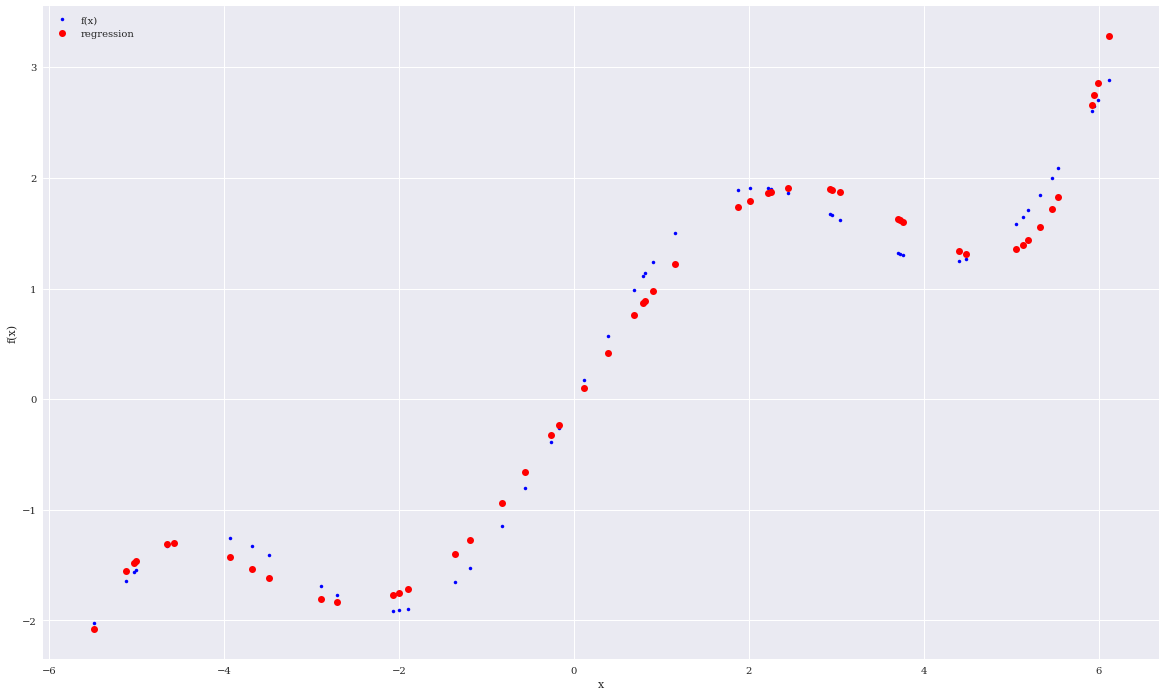

In [28]:
create_plot([xu, xu], [yu, ry], ['b.', 'ro'], ['f(x)', 'regression'], ['x', 'f(x)'])

In [29]:
'''
Next, regression over 2 variable space
'''
def fm(p):
    x, y = p
    return np.sin(x) + 0.25 + np.sqrt(y) + 0.05 * y ** 2 # made up function space
x = np.linspace(0, 10, 20)
y = np.linspace(0, 10, 20)
X, Y = np.meshgrid(x, y) # generate coordinate grid

In [30]:
Z = fm((X, Y))
x = x.flatten()
y = y.flatten()

In [31]:
from mpl_toolkits.mplot3d import Axes3D

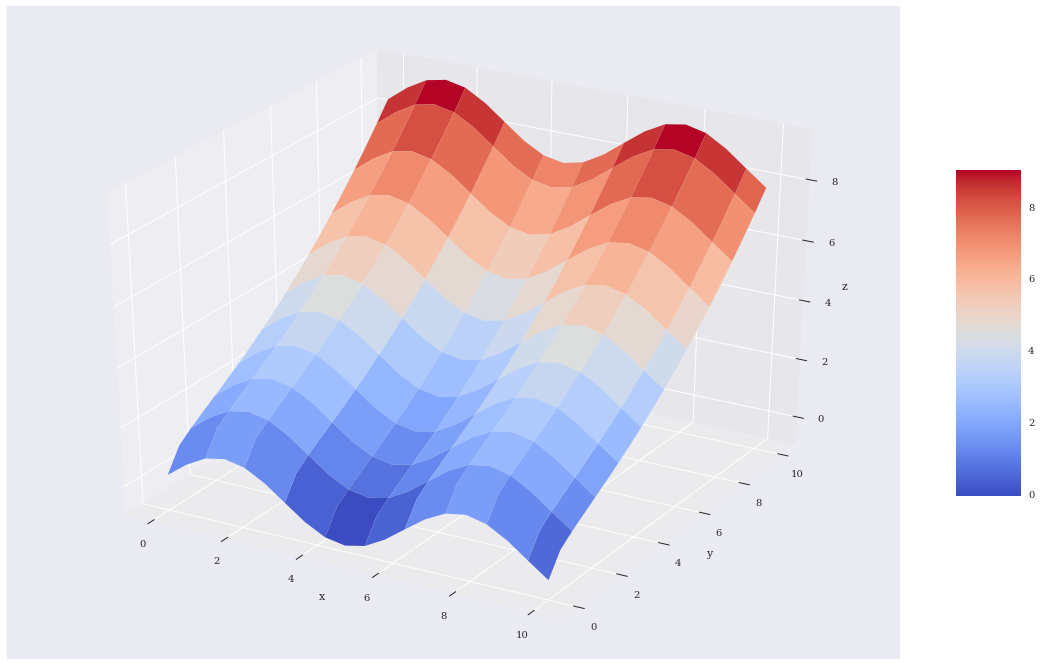

In [32]:
fig = plt.figure(figsize=(20,12))
ax = fig.gca(projection='3d') # get current axes, set to a 3d projection - sets us up for X,Y,Z mesh mapping
surf = ax.plot_surface(X, Y, Z, rstride=2, cstride=2, cmap='coolwarm', linewidth=0.5, antialiased=True)
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
fig.colorbar(surf, shrink=0.5, aspect=5)

In [58]:
'''
In higher dimension regression, having some knowledge of the basis functions is essential for meaningful
regression results
'''
matrix = np.zeros((len(x), 6 + 1))
matrix[:, 6] = np.sqrt(y)  
matrix[:, 5] = np.sin(x)
matrix[:, 4] = y ** 2
matrix[:, 3] = x ** 2
matrix[:, 2] = y
matrix[:, 1] = x
matrix[:, 0] = 1

//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in sqrt
  


In [59]:
reg = np.linalg.lstsq(matrix, fm((x, y)), rcond=None)[0] # Regression basis, points to fit
reg

LinAlgError: SVD did not converge in Linear Least Squares

In [60]:
# RZ = np.dot(matrix, reg).reshape((20, 20)) This is in the original text but is broken, need to provide this
# function that generates the raw function mesh manually
def reg_func(a, p):
    x, y = p
    f6 = a[6] * np.sqrt(y)
    f5 = a[5] * np.sin(x)
    f4 = a[4] * y ** 2
    f3 = a[3] * x ** 2
    f2 = a[2] * y
    f1 = a[1] * x
    f0 = a[0] * 1
    return (f6 + f5 + f4 + f3 +
            f2 + f1 + f0)
RZ = reg_func(reg, (X, Y))

//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in sqrt
  """


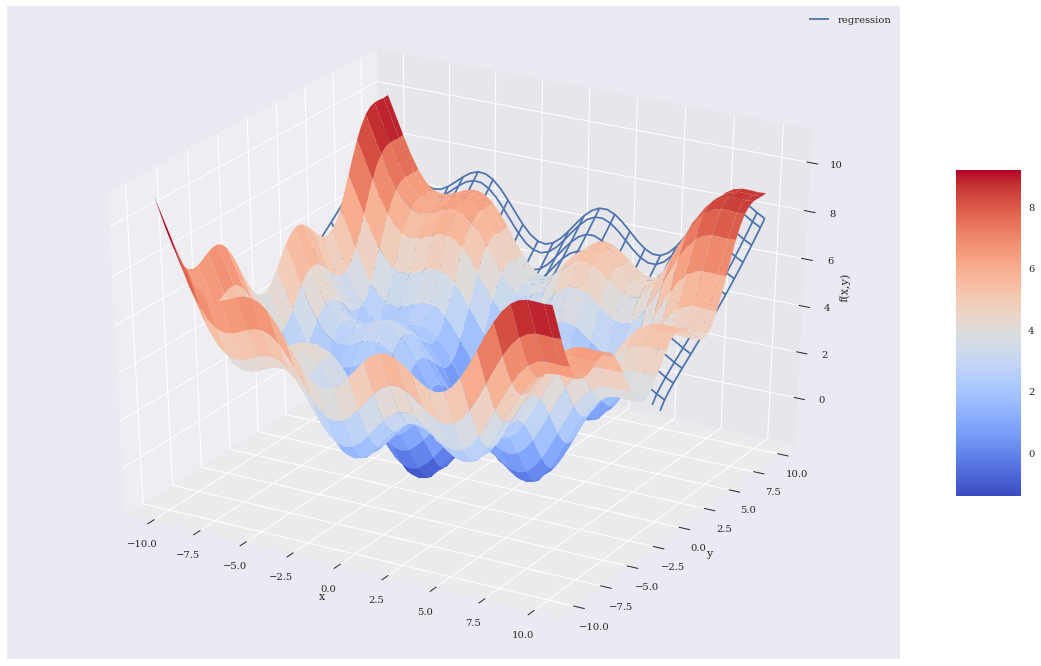

In [61]:
fig = plt.figure(figsize=(20, 12))
ax = fig.gca(projection='3d')
surf1 = ax.plot_surface(X, Y, Z, rstride=2, cstride=2, cmap=mpl.cm.coolwarm, linewidth=0.5, antialiased=True)
surf2 = ax.plot_wireframe(X, Y, RZ, rstride=2, cstride=2, label='regression') # regression mesh
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('f(x,y)')
ax.legend()
fig.colorbar(surf, shrink=0.5, aspect=5)

In [62]:
'''
Interpolation: regression between neighboring points to make delta(p1, p2) = 0 @ join points and also make 
function continuously differentiable.

To be continuously differentiable requires the piecewise splines are of *at least* degree 3: 
cubic spline interpolation.

Application of this is for bootstrapping a yield curve
'''
import scipy.interpolate as spi

In [63]:
x = np.linspace(-2 * np.pi, 2 * np.pi, 25)

In [64]:
def f(x):
    return np.sin(x) + 0.5 * x

In [65]:
ipo = spi.splrep(x, f(x), k=1) # linear interpolation

In [66]:
iy = spi.splev(x, ipo) # Interpolate over curved surface

In [67]:
np.allclose(iy, f(x)) # Are the spline interpolation points close to the function surface?

True

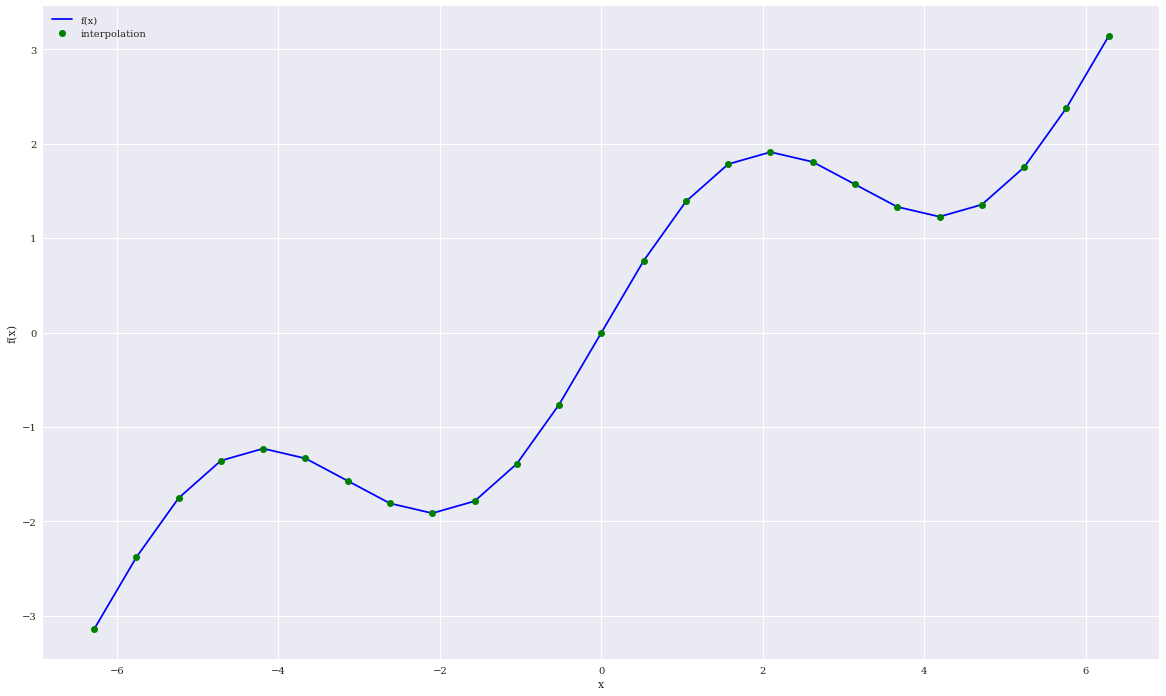

In [68]:
create_plot([x, x], [f(x), iy], ['b', 'go'], ['f(x)', 'interpolation'], ['x', 'f(x)'])

In [69]:
'''
"Spline interpolation is often used in finance to generate estimates for dependent values of 
independent data points not included in the original observations" i.e. any non-continuous price, rate,
time when no trades took place

Interpolation starts to fall apart at smaller intervals with more points
'''
xd = np.linspace(1.0, 3.0, 50)
iyd = spi.splev(xd, ipo)

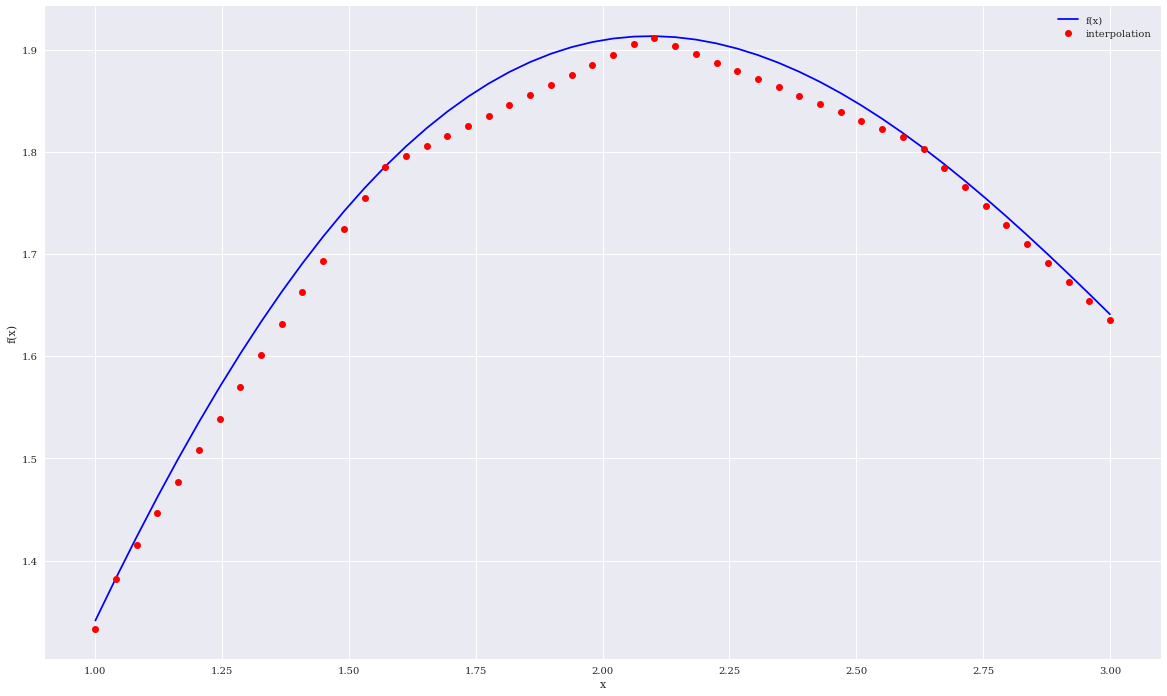

In [70]:
# Note here function is not continuously differentiable at data points from the actual function - not good!
create_plot([xd,xd], [f(xd), iyd], ['b', 'ro'], ['f(x)', 'interpolation'], ['x', 'f(x)'])

In [71]:
# What to do? Fit with higher degree splines! In this case cubic
ipo = spi.splrep(x, f(x), k=3)
iyd = spi.splev(xd, ipo)

In [72]:
np.allclose(iyd, f(xd)) # not a perfect interpolation

False

In [73]:
np.mean((f(xd) - iyd)  ** 2) # Pretty small MSE!

1.1349319851436892e-08

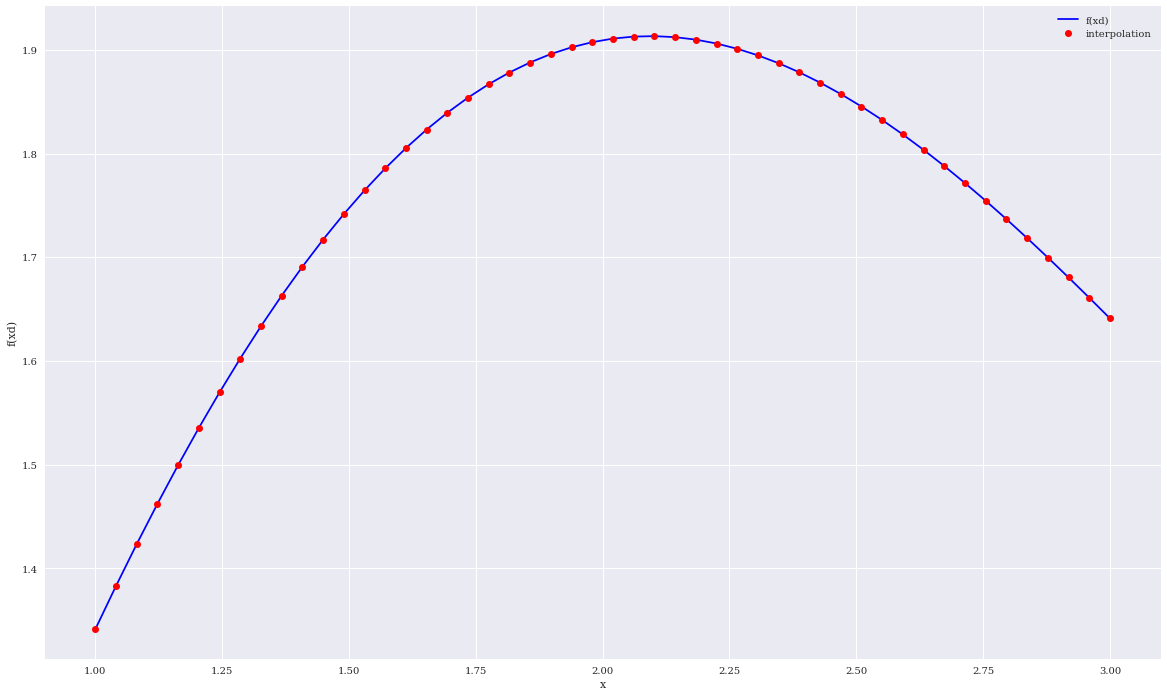

In [74]:
# Way better
create_plot([xd, xd], [f(xd), iyd], ['b', 'ro'], ['f(xd)', 'interpolation'], ['x', 'f(xd)'])

In [75]:
'''
Synthesis: When you know you're dealing with a non-noisy function, 
linear interpolation performs better than regression
'''

"\nSynthesis: When you know you're dealing with a non-noisy function, \nlinear interpolation performs better than regression\n"

In [76]:
'''
Onwards to convex optimization - optimization is the process of minimizing a function given constraints.
In this case, the function will produce a convex surface

Finance examples: calibrating option pricing to market data or agent utility problems

Let's make a 3d sinusoidal surface to start!
'''
def fm(p):
    x, y = p
    return (np.sin(x) + 0.05 * x ** 2 + np.sin(y) + 0.05 * y ** 2)


In [77]:
x = np.linspace(-10, 10, 50)
y = np.linspace(-10, 10, 50)
X, Y = np.meshgrid(x, y)
Z = fm((X, Y))

'\nThere are multiple local minimums in various parts of the fold here, but a global does seem to be present in the \ninner folds\n'

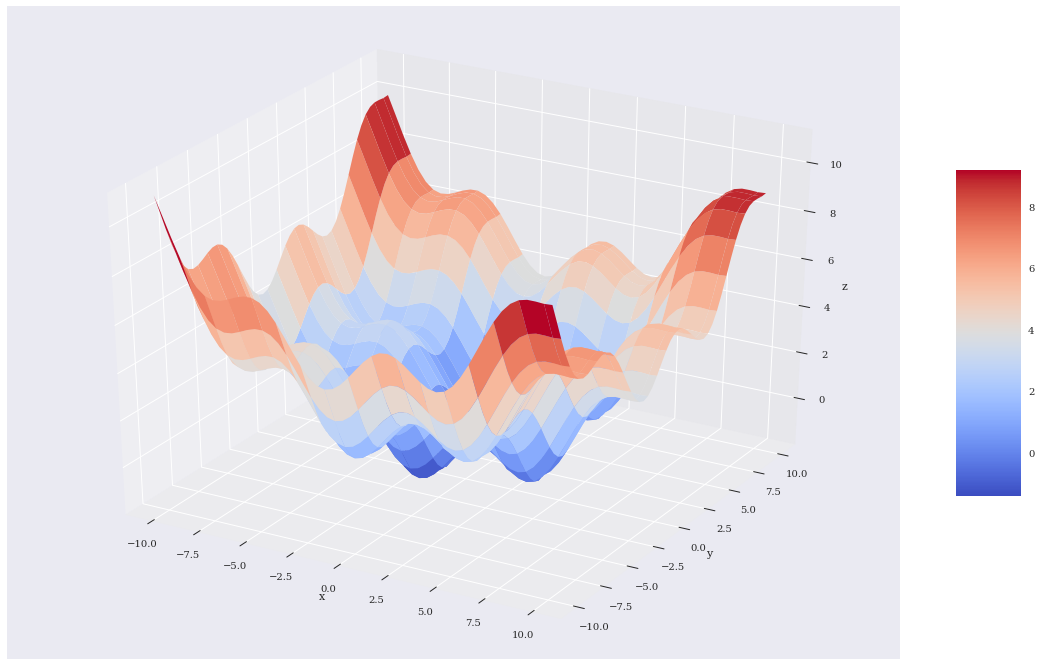

In [78]:
 fig = plt.figure(figsize=(20,12))
ax = fig.gca(projection='3d')
surf = ax.plot_surface(X, Y, Z, rstride=2, cstride=3, cmap='coolwarm', linewidth=0.5, antialiased=True)
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
fig.colorbar(surf, shrink=0.5, aspect=5)
'''
There are multiple local minimums in various parts of the fold here, but a global does seem to be present in the 
inner folds
'''

In [81]:
'''
Let's implement both a global minimization and a local minimization
'''
import scipy.optimize as sco

In [90]:
def fo(p):
    x, y = p
    z = np.sin(x) + 0.05 * x ** 2 + np.sin(y) + 0.05 * y ** 2
    if output == True:
        print('%8.4f | %8.4f | %8.4f' % (x, y, z))
    return z

In [91]:
'''
Brute force minimum search between -10 and 10 on both independent variables, with a step size of 5 between them
Note that the process runs the formula for all combinations of the two independent variables over the step size
and outputs to minimum found
'''
output = True
sco.brute(fo, ((-10, 10.1, 5), (-10, 10.1, 5)), finish=None)  

-10.0000 | -10.0000 |  11.0880
-10.0000 |  -5.0000 |   7.7529
-10.0000 |   0.0000 |   5.5440
-10.0000 |   5.0000 |   5.8351
-10.0000 |  10.0000 |  10.0000
 -5.0000 | -10.0000 |   7.7529
 -5.0000 |  -5.0000 |   4.4178
 -5.0000 |   0.0000 |   2.2089
 -5.0000 |   5.0000 |   2.5000
 -5.0000 |  10.0000 |   6.6649
  0.0000 | -10.0000 |   5.5440
  0.0000 |  -5.0000 |   2.2089
  0.0000 |   0.0000 |   0.0000
  0.0000 |   5.0000 |   0.2911
  0.0000 |  10.0000 |   4.4560
  5.0000 | -10.0000 |   5.8351
  5.0000 |  -5.0000 |   2.5000
  5.0000 |   0.0000 |   0.2911
  5.0000 |   5.0000 |   0.5822
  5.0000 |  10.0000 |   4.7471
 10.0000 | -10.0000 |  10.0000
 10.0000 |  -5.0000 |   6.6649
 10.0000 |   0.0000 |   4.4560
 10.0000 |   5.0000 |   4.7471
 10.0000 |  10.0000 |   8.9120


array([0., 0.])

In [94]:
'''
Specifying a smaller step size when brute force optimizing increases the precision of the minima found, at the
cost of additional compute power
'''
output=False
opt1 = sco.brute(fo, ((-10, 10, 0.1), (-10, 10, 0.1)), finish=None)
opt1

array([-1.4, -1.4])

In [95]:
fm(opt1)

-1.7748994599769203

In [97]:
'''
Now that we've found the general region in which the global minima lies, we can run a local convex optimization
over that interval
'''
output = True
'''
Find the local minimum with a input tolerance and function tolerance of 0.0001, iterating a max of 15 times
calling the function a max of 20 times
'''
opt2 = sco.fmin(fo, opt1, xtol=0.0001, ftol=0.001, maxiter=15, maxfun=20)


 -1.4000 |  -1.4000 |  -1.7749
 -1.4700 |  -1.4000 |  -1.7743
 -1.4000 |  -1.4700 |  -1.7743
 -1.3300 |  -1.4700 |  -1.7696
 -1.4350 |  -1.4175 |  -1.7756
 -1.4350 |  -1.3475 |  -1.7722
 -1.4088 |  -1.4394 |  -1.7755
 -1.4438 |  -1.4569 |  -1.7751
 -1.4328 |  -1.4427 |  -1.7756
 -1.4591 |  -1.4208 |  -1.7752
 -1.4213 |  -1.4347 |  -1.7757
 -1.4235 |  -1.4096 |  -1.7755
 -1.4305 |  -1.4344 |  -1.7757
 -1.4168 |  -1.4516 |  -1.7753
 -1.4305 |  -1.4260 |  -1.7757
 -1.4396 |  -1.4257 |  -1.7756
 -1.4259 |  -1.4325 |  -1.7757
 -1.4259 |  -1.4241 |  -1.7757
 -1.4304 |  -1.4177 |  -1.7757
 -1.4270 |  -1.4288 |  -1.7757


In [98]:
opt2 # x, y parameters for local minimum

array([-1.42702972, -1.42876755])

In [100]:
fm(opt2) # evaluate function with local minimum parameters

-1.7757246992239009

In [102]:
output=False
sco.fmin(fo, (2.0, 2.0), maxiter=250) # Doing an fmin in a poorly defined global space gives a local minima

Optimization terminated successfully.
         Current function value: 0.015826
         Iterations: 46
         Function evaluations: 86


array([4.2710728 , 4.27106945])

In [103]:
'''
Onwards to constrained optimization: this family is useful for agent utility maximization subject to constraints

These problems need to be posed as "What is the optimal choice given a vector of payoff profiles with probabilities?"

The vector object is defined as:
Price(i), Payoff(i), Probability(i).

Given a budget w(0) at the start and a payoff function f(x), what is the optimal number of shares to buy for each?

A specific example:
Maximize Expected Value E(u(w1)) = p * sqrt(wealth_end(u) + (1-p) * sqrt(wealth_end(d))
wealth_end = a * r(a) + b * r(b)
wealth_begin > a * q(a) + b * q(b)
a, b > 0

if p(u) = 0.5, p(d) = 0.5, state u payoff = (15, 5) and state d payoff = (5, 12), and security a and b = 10:

min(a,b) -expected_value(u(wealth_end)) = - (0.5 * sqrt(wealth_end(u)) + 0.5 * squrt(wealth_end(d)))
wealth_end(u) = a * 15 + b * 5
wealth_end(d) + a * 5 + b * 12
100 > a * 10 + b * 10
a,b > 0

This can be solved with the scipy.optimize.minimize() function. This function takes in a list of equalities and
inequalities as a list of dict objects as well as parameter boundaries as a tuple of tuples

'''


'\nOnwards to constrained optimization: this family is useful for agent utility maximization subject to constraints\n\nThese problems need to be posed as "What is the optimal choice given a vector of payoff profiles with probabilities?"\n\nThe vector object is defined as:\nPrice(i), Payoff(i), Probability(i).\n\nGiven a budget w(0) at the start and a payoff function f(x), what is the optimal number of shares to buy for each?\n\nA specific example:\nMaximize Expected Value E(u(w1)) = p * sqrt(wealth_end(u) + (1-p) * sqrt(wealth_end(d))\nwealth_end = a * r(a) + b * r(b)\nwealth_begin > a * q(a) + b * q(b)\na, b > 0\n\nif p(u) = 0.5, p(d) = 0.5, state u payoff = (15, 5) and state d payoff = (5, 12), and security a and b = 10:\n\nmin(a,b) -expected_value(u(wealth_end)) = - (0.5 * sqrt(wealth_end(u)) + 0.5 * squrt(wealth_end(d)))\nwealth_end(u) = a * 15 + b * 5\nwealth_end(d) + a * 5 + b * 12\n100 > a * 10 + b * 10\na,b > 0\n\nThis can be solved with the scipy.optimize.minimize() function. 

In [104]:
import math
def Eu(p):
    s, b = p
    return -(0.5 * math.sqrt(s * 15 + b * 5) + 0.5 * math.sqrt(s * 5 + b * 12))

In [105]:
cons = ({'type': 'ineq', 'fun': lambda p: 100 - p[0] * 10 - p[1] * 10})

In [109]:
bnds = ((0, 1000), (0, 1000))

In [113]:
result = sco.minimize(Eu, [5, 5], method='SLSQP',
                                bounds=bnds, constraints=cons)

In [114]:
result['x'] # Optimal investment strategy - just over 8 of sec A, just under 2 of sec B

array([8.02547122, 1.97452878])

In [115]:
-result['fun'] # The minimum value achieved by the optimization

9.700883611487832

In [117]:
np.dot(result['x'], [10,10]) # All wealth was invested

99.99999999999999

In [118]:
'''
On to integration.
The value of a derivative is the discounted expected payoff. This payoff is the integral in the continuous case.
'''
import scipy.integrate as sci

In [119]:
def f(x):
    return np.sin(x) + 0.5 * x

In [128]:
# Integrate this over the definite space from 0.5 to 9.5
x = np.linspace(0,10)
y = f(x)
a = 0.5
b = 9.5

In [129]:
from matplotlib.patches import Polygon

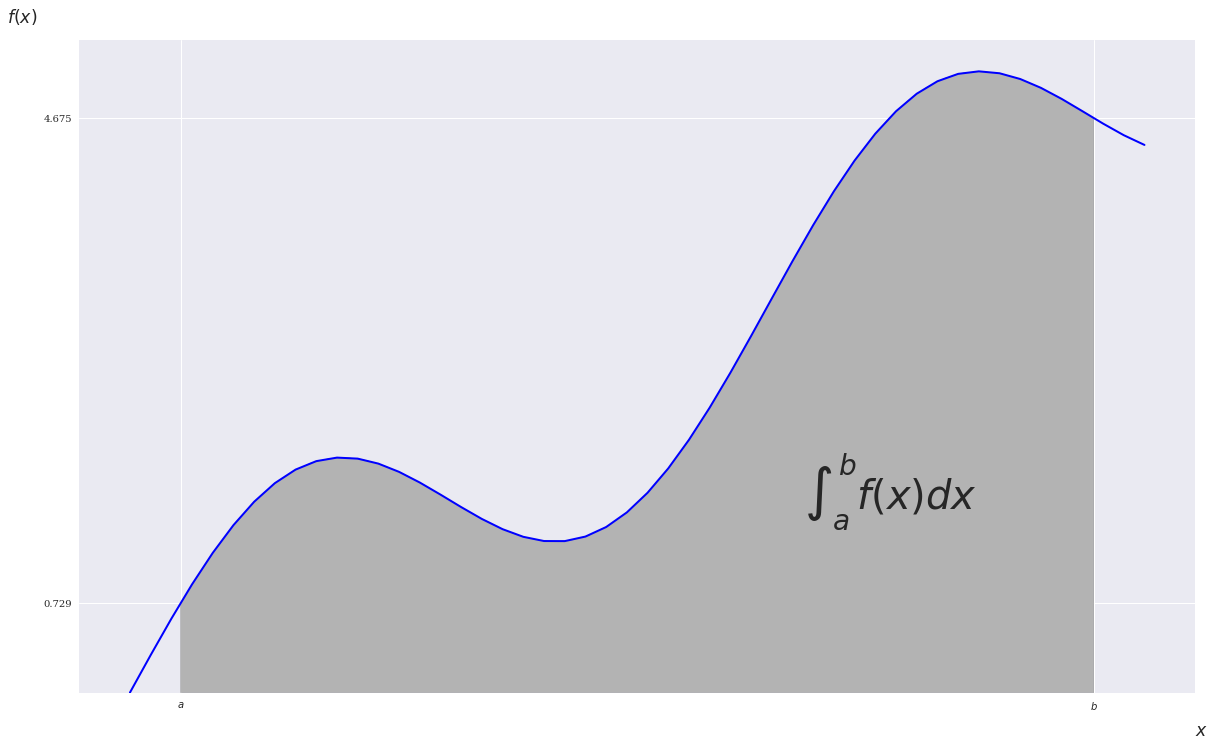

In [153]:
fig, ax = plt.subplots(figsize=(20,12))
plt.plot(x, y, 'b', linewidth=2)
plt.ylim(bottom=0)
Ix = np.linspace(a, b)
Iy = f(Ix)
verts = [(a, 0)] + list(zip(Ix, Iy)) + [(b, 0)]
poly = Polygon(verts, facecolor='0.7', edgecolor='0.5')
ax.add_patch(poly)
plt.text(0.75 * (a + b), 1.5, r"$\int_a^b f(x) dx$", horizontalalignment='center', fontsize=40)
plt.figtext(0.9, 0.075, '$x$', fontsize='xx-large')
plt.figtext(0.075, 0.9, '$f(x)$', fontsize='xx-large')
ax.set_xticks((a,b))
ax.set_xticklabels(('$a$', '$b$'))
ax.set_yticks([f(a), f(b)])


In [154]:
'''
Scipy.integrate contains different numerical methods for definite integration: Gaussian quadrature, adapitive
quadrature, and Romberg integration
'''
sci.fixed_quad(f, a, b)[0] # Gaussian Quad

24.366995967084602

In [155]:
sci.quad(f, a, b)[0] # Adaptive Quad

24.374754718086752

In [156]:
sci.romberg(f,a, b)

24.374754718086713

In [157]:
xi = np.linspace(0.5, 9.5, 25)

In [158]:
sci.trapz(f(xi), xi) # Integrate over this space with Trapezoidal rule

24.352733271544516

In [159]:
sci.simps(f(xi), xi) # Integration over this space with Simpsons rule

24.37496418455075

In [160]:
'''
Monte Carlo Integration
- Draw I random values of x between integral limits.
- Evaluate function at f(x) for all i in I
- sum evaluation values and take mean
'''
for i in range(1,20):
    np.random.seed(1000)
    x = np.random.random(i * 10) * (b - a) + a
    print(np.mean(f(x)) * b - a)

25.68280462818321
27.496414392684176
27.224744603625307
26.973686921629252
25.88840524854224
24.708577371711755
24.335018512334546
24.313849751125716
24.48749898626266
24.494933216955268
25.281312913872597
25.08561675497567
24.955141198571848
25.281091542431547
24.754096029452327
25.03900001584979
24.95720106593038
24.9396182035324
24.5895539372825
